In [1]:
import os
import pandas
import geopandas
import numpy as np
from matplotlib import pyplot as plt
import time
g = 0
debug = 1

thisyear = 2018
data_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/districts_with_data/'
shapefiledir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/{0:.0f}/'.format(thisyear)
extras_dir = '/home/idies/workspace/Storage/raddick/census/extras/'

district_color_cycle = ['red', 'green', 'orange', 'cyan', 'yellow', 'pink', 'gray']

print('ok')

ok


In [64]:
s = time.time()
bg_file_list = [shapefiledir+'BG/'+x for x in os.listdir(shapefiledir+'BG/') if ((x[-4:] == '.shp'))]
bg_gdf = geopandas.GeoDataFrame()

print('Reading block groups...')
for i in range(0, len(bg_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(bg_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(bg_file_list)))
    bg_gdf_i = geopandas.read_file(bg_file_list[i])
    bg_gdf = pandas.concat((bg_gdf, bg_gdf_i), axis=0, sort=False)

print('converting block group identifiers and coords to numeric...')
bg_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(bg_gdf['STATEFP'], errors='coerce')
bg_gdf.loc[:, 'COUNTYFP'] = pandas.to_numeric(bg_gdf['COUNTYFP'], errors='coerce')
bg_gdf.loc[:, 'TRACTCE'] = pandas.to_numeric(bg_gdf['TRACTCE'].apply(lambda x: x[0:4]+'.'+x[4:]), errors='coerce')
bg_gdf.loc[:, 'BLKGRPCE'] = pandas.to_numeric(bg_gdf['BLKGRPCE'], errors='coerce')
bg_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(bg_gdf['INTPTLAT'], errors='coerce')
bg_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(bg_gdf['INTPTLON'], errors='coerce')

#bg_gdf.loc[:, 'NAME'] = pandas.to_numeric(tract_gdf['NAME'], errors='coerce')
# bg_gdf = tract_gdf.sort_values(by='NAME')

print('assigning GEOID as index...')
bg_gdf.loc[:, 'GEOID'] = bg_gdf['GEOID'].apply(lambda x: '15000US'+str(x))
bg_gdf = bg_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)
if (debug >= 1):
    print('Read {0:,.0f} census block groups in {1:,.1f} seconds!'.format(len(bg_gdf), e-s))

#bg_gdf.sample(1).T

print('reading original congressional districts with urban/rural data...')
cd_gdf = geopandas.read_file(data_dir+'cd116_with_areas_and_types_435.shp')

print('Fixing at-large districts by setting district number to 1...')
cd_gdf.loc[cd_gdf['CD116FP'] == 0, 'CD116FP'] = 1  # At-large districts will be called District 1

cd_gdf = cd_gdf.rename(columns = {'pct_metro_': 'pct_metro_area', 'pct_city_a': 'pct_city_area'})
cd_gdf.loc[:, 'CD116FP'] = cd_gdf['CD116FP'].apply(lambda x: int(x))
cd_gdf = cd_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)
print('Read {0:,.0f} original districts in {1:,.1f} seconds.'.format(len(cd_gdf), e-s))
#sorted(cd_gdf[cd_gdf['CD116FP'] == 0]['STUSAB'].tolist())

print('reading districts that have been matched so far...')
assembler_df = pandas.read_csv(data_dir+'block_group_with_district_1_7.csv', encoding='utf-8', index_col='GEOID')
assembler_gdf = geopandas.GeoDataFrame(assembler_df.join(bg_gdf.geometry))
assembler_gdf.loc[:, 'block_based_district'] = pandas.to_numeric(assembler_gdf['block_based_district'], errors='coerce')

print('backing up...')
cd_gdf_bk = cd_gdf
assembler_gdf_bk = assembler_gdf

e = time.time()
g = g + (e-s)
print('Read {0:,.0f} district-marked block groups in {1:,.1f} seconds!'.format(len(bg_gdf),e-s))




Reading block groups...
	Reading file 1 of 51...
	Reading file 11 of 51...
	Reading file 21 of 51...
	Reading file 31 of 51...
	Reading file 41 of 51...
	Reading file 51 of 51...
converting block group identifiers and coords to numeric...
assigning GEOID as index...
Read 217,739 census block groups in 133.0 seconds!
reading original congressional districts with urban/rural data...
Fixing at-large districts by setting district number to 1...
Read 435 original districts in 135.3 seconds.
reading districts that have been matched so far...
backing up...
Read 217,739 district-marked block groups in 137.4 seconds!


# Fixing districts for contiguity

In [65]:
print('Fixing Idaho...')
assembler_gdf.loc['15000US160010105031', 'block_based_district'] = 2
print('Fixing Nebraska...')
assembler_gdf.loc['15000US311530106183', 'block_based_district'] = 1
print('Fixing New Mexico...')
assembler_gdf.loc['15000US350010047201', 'block_based_district'] = 3
print('Fixing Arkansas...')
assembler_gdf.loc[['15000US051011802002', '15000US051310101022'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US051299701002', '15000US050690025001'], 'block_based_district'] = 1
print('Fixing Kansas...')
assembler_gdf.loc['15000US201459703001', 'block_based_district'] = 1
assembler_gdf.loc['15000US201211004001', 'block_based_district'] = 2
print('Fixing Nevada...')
assembler_gdf.loc['15000US320030050161', 'block_based_district'] = 4
print('Fixing Utah...')
assembler_gdf.loc['15000US490351139071', 'block_based_district'] = 2
assembler_gdf.loc[['15000US490351101041', '15000US490351101042'], 'block_based_district'] = 3
print('Fixing Connecticut...')
assembler_gdf.loc[['15000US090053108041', '15000US090075412001'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US090093519002', '15000US090093516024', '15000US090093528002', '15000US090093514003', '15000US090093517002'], 'block_based_district'] = 3
assembler_gdf.loc['15000US090093516022', 'block_based_district'] = 5
print('Fixing Oregon...')
assembler_gdf.loc[['15000US410050223012', '15000US410050223013'], 'block_based_district'] = 3
print('Fixing Kentucky...')
assembler_gdf.loc[['15000US212150801032', '15000US212150802003', '15000US212150801032', '15000US212150801032'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US212150801021', '15000US212150801022', '15000US212150802002'], 'block_based_district'] = 4
print('Fixing Louisiana...')
assembler_gdf.loc[['15000US220379515022', '15000US220379516004', '15000US220379515021', '15000US220330030002'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US220979618001'], 'block_based_district'] = 4  # was 3
assembler_gdf.loc[['15000US221059540021'], 'block_based_district'] = 1  # was 5
assembler_gdf.loc[['15000US220479529003'], 'block_based_district'] = 2 # was 6
assembler_gdf.loc[['15000US220890621003'], 'block_based_district'] = 2  # was 6
assembler_gdf.loc[['15000US220070501003'], 'block_based_district'] = 6 # was 2                   
assembler_gdf.loc[['15000US220890622001', '15000US220050304021'], 'block_based_district'] = 6 #  was 2
assembler_gdf.loc[['15000US220510248003'], 'block_based_district'] = 2  # was 1
assembler_gdf.loc[['15000US220050303001', '15000US220050303002', '15000US220050306001', '15000US220050304022', '15000US220050304023'], 'block_based_district'] = 2  # was 6
assembler_gdf.loc[['15000US220950701002'], 'block_based_district'] = 6 #  was 2
assembler_gdf.loc[['15000US220950702001', '15000US220710144001', '15000US220710133021'], 'block_based_district'] = 2   # was 1
assembler_gdf.loc[['15000US220510249002', '15000US220710129002'], 'block_based_district'] = 1 #  was 2
print('Fixing Alabama...')
assembler_gdf.loc[['15000US010730112071', '15000US010730112091'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US010730059033', '15000US010730142033', '15000US010730123051'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US011010010002'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US010259579022'], 'block_based_district'] = 1

print('Fixed!')

Fixing Idaho...
Fixing Nebraska...
Fixing New Mexico...
Fixing Arkansas...
Fixing Kansas...
Fixing Nevada...
Fixing Utah...
Fixing Connecticut...
Fixing Oregon...
Fixing Kentucky...
Fixing Louisiana...
Fixing Alabama...
Fixed!


In [ ]:
print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
#for this_state in ['NE', 'NM', 'AR', 'KS', 'MS', 'NV', 'UT', 'CT', 'OK', 'OR', 'KY', 'LA']:

## COLORADO

1.3333333333334911
POPULATION IN EACH DISTRICT
District 1: 816,401
District 2: 803,354
District 3: 738,739
District 4: 799,108
District 5: 787,655
District 6: 801,996
District 7: 783,888


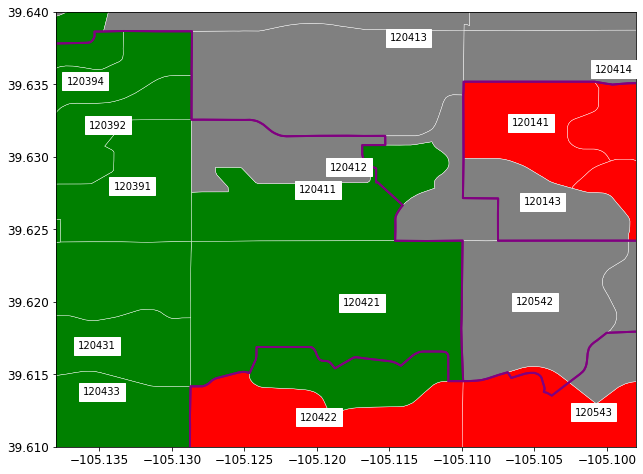

15000US080590120413
15000US080590120391
15000US080590120392
15000US080590120394
15000US080590120411
15000US080590120412
15000US080590120421
15000US080590120422
15000US080590120431
15000US080590120433
15000US080310120141
15000US080310120143
15000US080590120542
15000US080590120543
15000US080590120414


In [68]:
this_state = 'CO'
this_state_number = 8
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())
basesize = 8

assembler_gdf.loc[['15000US080140311002'], 'block_based_district'] = 2   #  was 2

assembler_gdf.loc[['15000US080590605003'], 'block_based_district'] = 7   # was 7

assembler_gdf.loc[['15000US080310120143'], 'block_based_district'] = 7#5    # was 1
assembler_gdf.loc[['15000US080590120412'], 'block_based_district'] = 7#4    # was 1

# # WHOLE STATE
# xlimits = (-109.2,-101.8)
# ylimits = (36.8,41.2)

# CENTER
xlimits = (-106.9,-104.1)
ylimits = (39,40.2)

# 2 VS 3
# xlimits = (-106.65,-106.42)
# ylimits = (39.4,39.8)

# DENVER METRO
xlimits = (-105.45,-104.3)
ylimits = (39.48,40.08)

# NORTH DENVER
# xlimits = (-105.3,-104.94)
# ylimits = (39.85,40.08)

# SOUTH DENVER
xlimits = (-105.138,-105.098)
ylimits = (39.61,39.64)


try:
    dummy = water_gdf.head(1).index.values[0]
except NameError:
    print('reading water shapefiles in {0:}...'.format(this_state))
    water_gdf = geopandas.GeoDataFrame()
    water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]
    for i in range(0, len(water_file_list)):
        if (debug >= 1):
            if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
                print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
        water_gdf_i = geopandas.read_file(water_file_list[i])
        #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
        water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)
    water_gdf = water_gdf.set_index('HYDROID')

aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)


fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='white', linewidth=0.05*basesize
    )

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='purple', lw=0.25*basesize
    )
    
#water_gdf.plot(ax=ax, color='blue')

b = []
for ix, thisrow in assembler_gdf[
#    (assembler_gdf.index != '15000US080590120542')
    (assembler_gdf['STUSAB'] == this_state) 
    & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
    & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
].iterrows():
    b.append(ix)
    annotator = ix[-6:]
    plt.annotate(annotator, 
                     (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
                     (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
                 color='black', backgroundcolor='white', fontsize=10, ha='center'
               )
    
plt.xticks(fontsize=1.5*basesize)
plt.yticks(fontsize=1.5*basesize)
    
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))

plt.xlim(xlimits)
plt.ylim(ylimits)

plt.show()

for x in b:
    print(x)




## ALABAMA FIXED TO BE CONTIGUOUS (7 CHANGES)

In [ ]:
this_state = 'AL'
this_state_number = 1
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())
basesize = 8

# assembler_gdf.loc[['15000US010730112071', '15000US010730112091'], 'block_based_district'] = 6
# assembler_gdf.loc[['15000US010730059033', '15000US010730142033', '15000US010730123051'], 'block_based_district'] = 7

# assembler_gdf.loc[['15000US011010010002'], 'block_based_district'] = 7
# assembler_gdf.loc[['15000US010259579022'], 'block_based_district'] = 1

# NORTH OF BIRMINGHAM
# xlimits = (-88.35,-85.05)
# ylimits = (33.7,35.3)

# DUE EAST OF BIRMINGHAM
# xlimits = (-86.5,-85.21)
# ylimits = (32.9,33.7)

# BIRMINGHAM METRO
# xlimits = (-87.05,-86.6)
# ylimits = (33.23,33.72)

# NE BIRMINGHAM
# xlimits = (-86.74,-86.6)
# ylimits = (33.55,33.69)

# N BIRMINGHAM
# xlimits = (-86.96,-86.75)
# ylimits = (33.55,33.63)

# W BIRMINGHAM
# xlimits = (-87.0,-86.86)
# ylimits = (33.56,33.6)

# TUSCALOOSA
# xlimits = (-87.73,-87.23)
# ylimits = (33.19,33.36)

# DUE WEST OF TUSCALOOSA
# xlimits = (-88.35,-87.6)
# ylimits = (32.9,33.7)

# SOUTH EXCEPT MOBILE
xlimits = (-88.5,-84.6)
ylimits = (30.9,33.3)

# MONTGOMERY
# xlimits = (-86.375,-86.1)
# ylimits = (32.15,32.45)

# # EAST SIDE OF MONTGOMERY
# xlimits = (-86.28,-86.1)
# ylimits = (32.15,32.45)

# # WEST SIDE OF MONTGOMERY
# xlimits = (-86.375,-86.23)
# ylimits = (32.33,32.38)

# JACKSON / GROVE HILL
# xlimits = (-88.2,-87.3)
# ylimits = (31.15,31.9)

# GROVE HILL CLOSE-UP
# xlimits = (-87.97,-87.81)
# ylimits = (31.48,31.6)

# MOBILE
# xlimits = (-88.7,-87.2)
# ylimits = (30.05,31.5)

try:
    dummy = water_gdf.head(1).index.values[0]
except NameError:
    print('reading water shapefiles in {0:}...'.format(this_state))
    water_gdf = geopandas.GeoDataFrame()
    water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]
    for i in range(0, len(water_file_list)):
        if (debug >= 1):
            if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
                print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
        water_gdf_i = geopandas.read_file(water_file_list[i])
        #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
        water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)
    water_gdf = water_gdf.set_index('HYDROID')

aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)


fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='white', linewidth=0.05*basesize
    )

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='purple', lw=0.25*basesize
    )
    
water_gdf.plot(ax=ax, color='blue')

# b = []
# for ix, thisrow in assembler_gdf[
# #    (assembler_gdf.index != '15000US011010011003')
#      (assembler_gdf['STUSAB'] == this_state) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-4:]
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#                )
    
plt.xticks(fontsize=1.5*basesize)
plt.yticks(fontsize=1.5*basesize)
    
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))

# plt.xlim(xlimits)
# plt.ylim(ylimits)

plt.show()

# for x in b:
#     print(x)


## LOUISIANA FIXED TO BE CONTIGUOUS (23 CHANGES)

In [ ]:
this_state = 'LA'
this_state_number = 22
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())


# BATON ROUGE
xlimits = (-91.5,-90.8)
ylimits = (30,31)

# BATON ROUGE WEIRDNESS
# xlimits = (-91,-90.8)
# ylimits = (30.16,30.26)

#xlimits = (-91.08,-90.75)
#ylimits = (30.06,30.4)



# # WEST/CENTER LAKE PONTCHARTRAIN
# xlimits = (-90.7,-90.1)
# ylimits = (29.7,30.5)

# # SOUTH LAKE PONTCHARTRAIN
# xlimits = (-90.4,-89.6)
# ylimits = (29.4,30.4)


#LAKE PONTCHARTRAIN WEIRDNESS WEST
# xlimits = (-90.54,-90.44)
# ylimits = (30.03,30.14)

#LAKE PONTCHARTRAIN WEIRDNESS CENTER
# xlimits = (-90.44,-90.28)
# ylimits = (29.92,30.01)

# # #LAKE PONTCHARTRAIN WEIRDNESS SOUTH
# xlimits = (-90.18,-90.08)
# ylimits = (29.89,29.986)

# ##LAKE PONTCHARTRAIN WEIRDNESS SOUTH II
# xlimits = (-90.1,-90)
# ylimits = (30,30.1)



# assembler_gdf.loc[['15000US220379515022', '15000US220379516004', '15000US220379515021', '15000US220330030002'], 'block_based_district'] = 6
# assembler_gdf.loc[['15000US220979618001'], 'block_based_district'] = 4  # was 3
# assembler_gdf.loc[['15000US221059540021'], 'block_based_district'] = 1  # was 5
# assembler_gdf.loc[['15000US220479529003'], 'block_based_district'] = 2 # was 6
# assembler_gdf.loc[['15000US220890621003'], 'block_based_district'] = 2  # was 6
# assembler_gdf.loc[['15000US220070501003'], 'block_based_district'] = 6 # was 2                   
# assembler_gdf.loc[['15000US220890622001', '15000US220050304021'], 'block_based_district'] = 6 #  was 2
# assembler_gdf.loc[['15000US220510248003'], 'block_based_district'] = 2  # was 1
# assembler_gdf.loc[['15000US220050303001', '15000US220050303002', '15000US220050306001', '15000US220050304022', '15000US220050304023'], 'block_based_district'] = 2  # was 6
# assembler_gdf.loc[['15000US220950701002'], 'block_based_district'] = 6 #  was 2
# assembler_gdf.loc[['15000US220950702001', '15000US220710144001', '15000US220710133021'], 'block_based_district'] = 2   # was 1
# assembler_gdf.loc[['15000US220510249002', '15000US220710129002'], 'block_based_district'] = 1 #  was 2


try:
    dummy = water_gdf.head(1).index.values[0]
except NameError:
    print('reading water shapefiles in {0:}...'.format(this_state))
    water_gdf = geopandas.GeoDataFrame()
    water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]
    for i in range(0, len(water_file_list)):
        if (debug >= 1):
            if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
                print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
        water_gdf_i = geopandas.read_file(water_file_list[i])
        #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
        water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)
    water_gdf = water_gdf.set_index('HYDROID')



aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)
basesize = 16

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='black', linewidth=0.01*basesize
    )

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='purple', lw=0.25*basesize
    )
    
#water_gdf.plot(ax=ax, color='blue')

# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf.index == '15000US220050304021')
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
# #     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#                )
    
# plt.xticks(fontsize=1.5*basesize)
# plt.yticks(fontsize=1.5*basesize)


    
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))


# plt.xlim(xlimits)
# plt.ylim(ylimits)

plt.show()

# for x in b:
#     print(x)
# assembler_gdf.groupby('block_based_district').size()
#assembler_gdf[assembler_gdf['block_based_district'] == -1]


## KENTUCKY FIXED TO BE CONTIGUOUS (7 CHANGES)

In [ ]:
this_state = 'KY'
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())

# assembler_gdf.loc[['15000US212150801032', '15000US212150802003', '15000US212150801032', '15000US212150801032'], 'block_based_district'] = 2
# assembler_gdf.loc[['15000US212150801021', '15000US212150801022', '15000US212150802002'], 'block_based_district'] = 4


# MISTAKEN DISTRICT 1
xlimits = (-85.6,-85.1)
ylimits = (37.93,38.18)

#     
#     


aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)
basesize = 8

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='black', linewidth=0.025*basesize
    )

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='purple', lw=0.25*basesize
    )


# b = []
# for ix, thisrow in assembler_gdf[
#     #(assembler_gdf.index != '15000US410050223013')
#     (assembler_gdf['STUSAB'] == this_state) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#                )

# plt.xlim(xlimits)
# plt.ylim(ylimits)

#plt.title('Changed block group {0:} (pop {1:,.0f} from CD 1 to CD 2)'.format(ix))
plt.xticks(fontsize=1.5*basesize)
plt.yticks(fontsize=1.5*basesize)
plt.show()

    
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))

# for x in b:
#     print(x)


## OREGON FIXED TO BE CONTIGUOUS (2 CHANGES)

In [ ]:
this_state = 'OR'
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())

#assembler_gdf.loc[['15000US410050223012', '15000US410050223013'], 'block_based_district'] = 3



# # # # # # NORTHWEST
# xlimits = (-124.5,-121.7)
# ylimits = (44,46.5)

# # # # # # METRO PORTLAND
# xlimits = (-122.8,-121.4)
# ylimits = (45,45.7)

# # # # # # SOUTH SIDE OF PORTLAND
# xlimits = (-122.61,-122.48)
# ylimits = (45.31,45.43)

# xlimits = (-122.615,-122.52)
# ylimits = (45.36,45.41)

aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)
basesize = 8

fig, ax = plt.subplots(1,1)#,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='black', linewidth=0.025*basesize
    )

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='purple', lw=0.25*basesize
    )


# b = []
# for ix, thisrow in assembler_gdf[
#     #(assembler_gdf.index != '15000US410050223013')
#     (assembler_gdf['STUSAB'] == this_state) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#                )

# plt.xlim(xlimits)
# plt.ylim(ylimits)

#plt.title('Changed block group {0:} (pop {1:,.0f} from CD 1 to CD 2)'.format(ix))
plt.xticks(fontsize=1.5*basesize)
plt.yticks(fontsize=1.5*basesize)
plt.show()

    
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))

# for x in b:
#     print(x)
    
    #   5


### OKLAHOMA is contiguous

In [ ]:
this_state = 'OK'
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())

# # # # # NORTH-CENTRAL
# xlimits = (-98,-95)
# ylimits = (34.5,37.2)

aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)
basesize = 8

fig, ax = plt.subplots(1,1)#,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='white', linewidth=0.025*basesize
    )

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='purple', lw=0.25*basesize
    )


# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#                )

# plt.xlim(xlimits)
# plt.ylim(ylimits)

#plt.title('Changed block group {0:} (pop {1:,.0f} from CD 1 to CD 2)'.format(ix))
plt.xticks(fontsize=1.5*basesize)
plt.yticks(fontsize=1.5*basesize)
plt.show()

# for x in b:
#     print(x)
    
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))



## CONNECTICUT FIXED TO BE CONTIGUOUS (8 CHANGES)

In [ ]:
this_state = 'CT'
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())

# assembler_gdf.loc[['15000US090053108041', '15000US090075412001'], 'block_based_district'] = 1
# assembler_gdf.loc[['15000US090093519002', '15000US090093516024', '15000US090093528002', '15000US090093514003', '15000US090093517002'], 'block_based_district'] = 3
# assembler_gdf.loc['15000US090093516022', 'block_based_district'] = 5

# # # # NORTH
# xlimits = (-73.25,-72.5)
# ylimits = (41.4,42.2)

# # # # 1 vs 5
# xlimits = (-73.25,-73.1)
# ylimits = (41.78,41.84)

# # # # 3 vs 4 vs 5
# xlimits = (-73.09,-72.99)
# ylimits = (41.505,41.565)

# 1 vs 3
# xlimits = (-72.71,-72.643)
# ylimits = (41.55,41.61)

aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)
basesize = 8

fig, ax = plt.subplots(1,1)#,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='white', linewidth=0.025*basesize
    )

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='purple', lw=0.25*basesize
    )


# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#                )

# plt.xlim(xlimits)
# plt.ylim(ylimits)

#plt.title('Changed block group {0:} (pop {1:,.0f} from CD 1 to CD 2)'.format(ix))
plt.xticks(fontsize=1.5*basesize)
plt.yticks(fontsize=1.5*basesize)
plt.show()

# for x in b:
#     print(x)
    
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))



## UTAH FIXED TO BE CONTIGUOUS (3 CHANGES)

In [ ]:
this_state = 'UT'
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())

# assembler_gdf.loc['15000US490351139071', 'block_based_district'] = 2
# assembler_gdf.loc[['15000US490351101041', '15000US490351101042'], 'block_based_district'] = 3



# # # # SALT LAKE CITY
# xlimits = (-112.5,-111)
# ylimits = (39.2, 41)

# # # # # NORTH SALT LAKE CITY
# xlimits = (-112.3,-111.5)
# ylimits = (40.55,40.75)

# # # # # NORTHEAST SALT LAKE CITY
# xlimits = (-111.83,-111.75)
# ylimits = (40.62,40.68)


aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)
basesize = 8

fig, ax = plt.subplots(1,1)#,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='yellow', linewidth=0.025*basesize
    )

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='purple', lw=0.25*basesize
    )


# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
# #     annotator = 'Changed block group {0:}'.format(ix)
# #     annotator += '\n(population {0:,.0f})'.format((thisrow['total_population']))
# #     annotator += '\nFROM CD 1 TO CD 2'
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#                )
# for x in b:
#     print(x)

# plt.xlim(xlimits)
# plt.ylim(ylimits)

#plt.title('Changed block group {0:} (pop {1:,.0f} from CD 1 to CD 2)'.format(ix))
plt.xticks(fontsize=1.5*basesize)
plt.yticks(fontsize=1.5*basesize)
plt.show()

# for x in b:
#     print(x)
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))



## NEVADA FIXED TO BE CONTIGUOUS (1 CHANGE)

In [ ]:
this_state = 'NV'
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())

#assembler_gdf.loc['15000US320030050161', 'block_based_district'] = 4

# # # WHOLE STATE
xlimits = (-120.2, -113.8)
ylimits = (34.8,42.1)

# 1 vs 3 vs 4
# xlimits = (-116,-114.6)
# ylimits = (35.9, 36.5)

# # LAS VEGAS
# xlimits = (-115.3,-115)
# ylimits = (36,36.25)

# # EAST LAS VEGAS
# xlimits = (-115.05,-114.98)
# ylimits = (36.04,36.14)

aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)
basesize = 8

fig, ax = plt.subplots(1,1)#,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='yellow', linewidth=0.025*basesize
    )
#water_gdf.plot(ax=ax, color='blue')

#assembler_gdf[assembler_gdf.index == '15000US051011802002'].plot(ax=ax, color='none', edgecolor='white', lw=10)

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='purple', lw=0.3*basesize
    )


# b = []
# for ix, thisrow in assembler_gdf[
#     assembler_gdf.index == '15000US320030050161'
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
# #     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
# #     annotator = 'Changed block group {0:}'.format(ix)
# #     annotator += '\n(population {0:,.0f})'.format((thisrow['total_population']))
# #     annotator += '\nFROM CD 1 TO CD 2'
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#                )
# for x in b:
#     print(x)

plt.xlim(xlimits)
plt.ylim(ylimits)

#plt.title('Changed block group {0:} (pop {1:,.0f} from CD 1 to CD 2)'.format(ix))
plt.xticks(fontsize=1.5*basesize)
plt.yticks(fontsize=1.5*basesize)
plt.show()

# for x in b:
#     print(x)
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))



### MISSISSIPPI is contiguous

In [ ]:
this_state = 'MS'
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())

# assembler_gdf.loc['15000US201459703001', 'block_based_district'] = 4
# assembler_gdf.loc['15000US201211004001', 'block_based_district'] = 2
## #assembler_gdf.loc['15000US201211001001', 'block_based_district'] = 2


# # # WHOLE STATE
xlimits = (-91.7,-87.9)
ylimits = (29.9,35.3)

aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)
basesize = 8

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='yellow', linewidth=0.025*basesize
    )
#water_gdf.plot(ax=ax, color='blue')

#assembler_gdf[assembler_gdf.index == '15000US051011802002'].plot(ax=ax, color='none', edgecolor='white', lw=10)

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='purple', lw=0.3*basesize
    )


# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
# #     annotator = 'Changed block group {0:}'.format(ix)
# #     annotator += '\n(population {0:,.0f})'.format((thisrow['total_population']))
# #     annotator += '\nFROM CD 1 TO CD 2'
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#                )
# for x in b:
#     print(x)

plt.xlim(xlimits)
plt.ylim(ylimits)

#plt.title('Changed block group {0:} (pop {1:,.0f} from CD 1 to CD 2)'.format(ix))
plt.xticks(fontsize=1.5*basesize)
plt.yticks(fontsize=1.5*basesize)
plt.show()

# for x in b:
#     print(x)
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))



## KANSAS FIXED TO BE CONTIGUOUS (2 CHANGES)

In [ ]:
this_state = 'KS'
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())

# assembler_gdf.loc['15000US201459703001', 'block_based_district'] = 4
# assembler_gdf.loc['15000US201211004001', 'block_based_district'] = 2
## #assembler_gdf.loc['15000US201211001001', 'block_based_district'] = 2


# # WHOLE STATE
xlimits = (-102.5, -94.5)
ylimits = (36.8,40.2)

# MIS-DONE DISTRICT 2 IN THE MIDDLE
# xlimits = (-99.6,-99.1)
# ylimits = (37.7,38.5)

# 2 vs. 3
# xlimits = (-95.1, -94.5)
# ylimits = (38.2,38.76)

# 2 vs. 3 SOUTH
# xlimits = (-94.75, -94.55)
# ylimits = (38.3,38.65)


aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)
basesize = 8

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='yellow', linewidth=0.025*basesize
    )
#water_gdf.plot(ax=ax, color='blue')

#assembler_gdf[assembler_gdf.index == '15000US051011802002'].plot(ax=ax, color='none', edgecolor='white', lw=10)

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='purple', lw=0.3*basesize
    )


# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
# #     annotator = 'Changed block group {0:}'.format(ix)
# #     annotator += '\n(population {0:,.0f})'.format((thisrow['total_population']))
# #     annotator += '\nFROM CD 1 TO CD 2'
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#                )
# for x in b:
#     print(x)

plt.xlim(xlimits)
plt.ylim(ylimits)

#plt.title('Changed block group {0:} (pop {1:,.0f} from CD 1 to CD 2)'.format(ix))
plt.xticks(fontsize=1.5*basesize)
plt.yticks(fontsize=1.5*basesize)
plt.show()

# for x in b:
#     print(x)
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))



## ARKANSAS DISTRICTS FIXED TO BE CONTIGUOUS (2 changes)

In [ ]:
this_state = 'AR'
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())

# assembler_gdf.loc[['15000US051011802002', '15000US051310101022'], 'block_based_district'] = 3
# assembler_gdf.loc[['15000US051299701002', '15000US050690025001'], 'block_based_district'] = 1
## assembler_gdf.loc[['15000US051310013021','15000US050330204012','15000US050330204013', '15000US050330206001', '15000US050330206002', '15000US050330206003', '15000US050330206004'], 'block_based_district'] = 4

# # WHOLE STATE
xlimits = (-94.7,-89.5)
ylimits = (32.8,36.7)

# # NW ARK
# xlimits = (-94.7,-92.7)
# ylimits = (35.5,36.7)

# WEIRDNESS
# xlimits = (-93.4,-92.6)
# ylimits = (35.5,36.2)

# WEIRDNESS
# xlimits = (-93.5,-92.8)
# ylimits = (34.9,35.3)

# WEIRDNESS
# xlimits = (-92.2,-91.6)
# ylimits = (34,34.6)

# TRANSFER FROM 3 TO 4 FOR POPULATION EVENAGE?
# xlimits = (-94.7,-93.6)
# ylimits = (34.9,35.8)

# xlimits = (-94.33,-94)
# ylimits = (35.1,35.6)

aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)
basesize = 8

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='yellow', linewidth=0.025*basesize
    )
#water_gdf.plot(ax=ax, color='blue')

#assembler_gdf[assembler_gdf.index == '15000US051011802002'].plot(ax=ax, color='none', edgecolor='white', lw=10)

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='purple', lw=0.3*basesize
    )


# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
# #     annotator = 'Changed block group {0:}'.format(ix)
# #     annotator += '\n(population {0:,.0f})'.format((thisrow['total_population']))
# #     annotator += '\nFROM CD 1 TO CD 2'
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#                )
# for x in b:
#     print(x)

plt.xlim(xlimits)
plt.ylim(ylimits)

#plt.title('Changed block group {0:} (pop {1:,.0f} from CD 1 to CD 2)'.format(ix))
plt.xticks(fontsize=1.5*basesize)
plt.yticks(fontsize=1.5*basesize)
plt.show()

# for x in b:
#     print(x)
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))



## NEW MEXICO DISTRICTS FIXED TO BE CONTIGUOUS (3 changes)

In [ ]:
this_state = 'NM'
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())

# assembler_gdf.loc['15000US350010047201', 'block_based_district'] = 1
# assembler_gdf.loc['15000US350010047461', 'block_based_district'] = 3
# assembler_gdf.loc['15000US350619703014', 'block_based_district'] = 1



# # WHOLE STATE
xlimits = (-109.2,-102.9)
ylimits = (31.5,37.3)

# # 2 vs 3 WEST
# xlimits = (-109.2,-107.2)
# ylimits = (34.5,35.5)

# # 2 vs 3 EAST
# xlimits = (-105.4,-102.9)
# ylimits = (34,35.3)

# # 2 vs 3 EAST: PORTALES?
# xlimits = (-103.36,-103.3)
# ylimits = (34.15,34.19)

# # 1 vs all
# xlimits = (-107.5,-105)
# ylimits = (34,35.8)

# 1 closeup NW  - changed 2 block groups
# xlimits = (-106.77,-106.65)
# ylimits = (35.175,35.225)

# 1 closeup S
# xlimits = (-106.75,-106.4)
# ylimits = (34.71,34.82)

aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)
basesize = 8

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='white', linewidth=0.1*basesize
    )
#water_gdf.plot(ax=ax, color='blue')

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='purple', lw=0.5*basesize
    )


# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
# #     annotator = 'Changed block group {0:}'.format(ix)
# #     annotator += '\n(population {0:,.0f})'.format((thisrow['total_population']))
# #     annotator += '\nFROM CD 1 TO CD 2'
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=18, ha='center'
#                )

plt.xlim(xlimits)
plt.ylim(ylimits)

#plt.title('Changed block group {0:} (pop {1:,.0f} from CD 1 to CD 2)'.format(ix))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# for x in b:
#     print(x)
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))

print('\n')

# for x in b:
#     print(x)

## NEBRASKA DISTRICTS FIXED TO BE CONTIGUOUS (1 change)

In [ ]:
this_state = 'NE'
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())

#assembler_gdf.loc['15000US311530106183', 'block_based_district'] = 2



# # WHOLE STATE
xlimits = (-104.2,-95.5)
ylimits = (39.8,43.2)

# # # 1 vs 3
xlimits = (-98,-95.5)
ylimits = (40.3,42.5)

# # 1 vs 2
xlimits = (-96.5,-95.7)
ylimits = (40.9,41.5)

# # AREA TO POSSIBLY FIX?
xlimits = (-96.025,-95.95)
ylimits = (41.1,41.2)

# # # # SLIGHT ZOOMOUT FROM AREA TO POSSIBLY FIX
# xlimits = (-96.1,-95.8)
# ylimits = (41,41.3)

aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)
basesize = 8

fig, ax = plt.subplots(1,1)#,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='white', linewidth=0.5
    )
#water_gdf.plot(ax=ax, color='blue')

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='purple', linewidth=2
    )

#cd_gdf[cd_gdf['CD116FP'] == 1].plot(ax=ax, color='none', edgecolor='purple', linewidth=3)

c = []
for ix, thisrow in assembler_gdf[
    assembler_gdf.index == '15000US311530106183'
#     (assembler_gdf['STUSAB'] == this_state) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
].iterrows():
    c.append(ix)
    annotator = ix #ix[-6:]
    annotator = 'Changed block group {0:}'.format(ix)
    annotator += '\n(population {0:,.0f})'.format((thisrow['total_population']))
    annotator += '\nFROM CD 2 TO CD 1'

    
    plt.annotate(annotator, 
                     (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
                     (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
                 color='black', backgroundcolor='white', fontsize=9, ha='center'
               )

plt.xlim(xlimits)
plt.ylim(ylimits)

#plt.title('Changed block group {0:} (pop {1:,.0f} from CD 1 to CD 2)'.format(ix))
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
plt.show()

# for x in b:
#     print(x)
print('POPULATION IN EACH DISTRICT')
for i in range(1,nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))


# for x in c:
#     print(x)

### MAINE DISTRICT BOUNDARIES ARE CONTIGUOUS

In [ ]:
this_state = 'ME'
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())

# # WHOLE STATE
xlimits = [-71.3, -68.4]
ylimits = [43.6, 44.6]

# # AREA TO BE FIXED
# xlimits = [-116.4,-115.7]
# ylimits = [43.1,43.75]

aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)
basesize = 8

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='white'
    )
#water_gdf.plot(ax=ax, color='blue')

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='white'
    )

#cd_gdf[cd_gdf['CD116FP'] == 1].plot(ax=ax, color='none', edgecolor='purple', linewidth=3)

# #b = []
# for ix, thisrow in assembler_gdf[
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
# #     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
#     (assembler_gdf.index == '15000US160010105031')
# ].iterrows():
# #    b.append(ix)
#     annotator = 'Changed block group {0:}'.format(ix)
#     annotator += '\n(population {0:,.0f})'.format((thisrow['total_population']))
#     annotator += '\nFROM CD 1 TO CD 2'
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=12, ha='center'
#                )

plt.xlim(xlimits)
plt.ylim(ylimits)

#plt.title('Changed block group {0:} (pop {1:,.0f} from CD 1 to CD 2)'.format(ix))
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
plt.show()

# for x in b:
#     print(x)
print('POPULATION IN EACH DISTRICT')
for i in [1,2]:
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))


### NEW HAMPSHIRE DISTRICT BOUNDARIES ARE CONTIGUOUS

In [ ]:
this_state = 'NH'
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())

# # WHOLE STATE
xlimits = [-71.8, -70.5]
ylimits = [42.6, 44.3]

# # AREA TO BE FIXED
# xlimits = [-116.4,-115.7]
# ylimits = [43.1,43.75]

#aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
#print(aspect_ratio)
#basesize = 8

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='white'
    )
#water_gdf.plot(ax=ax, color='blue')

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='white'
    )

#cd_gdf[cd_gdf['CD116FP'] == 1].plot(ax=ax, color='none', edgecolor='purple', linewidth=3)

# #b = []
# for ix, thisrow in assembler_gdf[
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
# #     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
#     (assembler_gdf.index == '15000US160010105031')
# ].iterrows():
# #    b.append(ix)
#     annotator = 'Changed block group {0:}'.format(ix)
#     annotator += '\n(population {0:,.0f})'.format((thisrow['total_population']))
#     annotator += '\nFROM CD 1 TO CD 2'
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=12, ha='center'
#                )

plt.xlim(xlimits)
plt.ylim(ylimits)

#plt.title('Changed block group {0:} (pop {1:,.0f} from CD 1 to CD 2)'.format(ix))
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
plt.show()

# for x in b:
#     print(x)
print('POPULATION IN EACH DISTRICT')
for i in [1,2]:
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))


## IDAHO DISTRICTS FIXED TO BE CONTIGUOUS (1 change)

In [ ]:
this_state = 'ID'

assembler_gdf.loc['15000US160010105031', 'block_based_district'] = 2

# WHOLE STATE
xlimits = [-116.4,-114]
ylimits = [41.9,46.1]

# AREA TO BE FIXED
# xlimits = [-116.4,-115.7]
# ylimits = [43.1,43.75]

aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
#print(aspect_ratio)
basesize = 8

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, int(assembler_gdf[(assembler_gdf['STUSAB'] == this_state)]['block_based_district'].max()+1)):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='yellow'
    )
#water_gdf.plot(ax=ax, color='blue')

cd_gdf[cd_gdf['CD116FP'] == 1].plot(ax=ax, color='none', edgecolor='purple', linewidth=3)

#b = []
for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
    (assembler_gdf.index == '15000US160010105031')
].iterrows():
#    b.append(ix)
    annotator = 'Changed block group {0:}'.format(ix)
    annotator += '\n(population {0:,.0f})'.format((thisrow['total_population']))
    annotator += '\nFROM CD 1 TO CD 2'
    plt.annotate(annotator, 
                     (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
                     (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
                 color='black', backgroundcolor='white', fontsize=12, ha='center'
               )

plt.xlim(xlimits)
plt.ylim(ylimits)

#plt.title('Changed block group {0:} (pop {1:,.0f} from CD 1 to CD 2)'.format(ix))
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
plt.show()

# for x in b:
#     print(x)
print('NEW POPULATION IN EACH DISTRICT')
for i in [1,2]:
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))


### HAWAII DISTRICT BOUNDARIES ARE CONTIGUOUS

In [ ]:
this_state = 'HI'

xlimits = [-158.4,-157.55]
ylimits = [21.19,21.78]

fig, ax = plt.subplots(1,1)
# # WESTERN SECTION OF BORDER IS GOOD
# xlimits = [-158.15,-158.05]
# ylimits = [21.28,21.4]

# CENTER SECTION OF BORDER IS GOOD
# xlimits = [-158.05,-157.87]
# ylimits = [21.38,21.52]

# EASTERN SECTION OF BORDER IS GOOD
# xlimits = [-157.87, -157.64]
# ylimits = [21.22, 21.44]

for i in range(1, int(assembler_gdf[(assembler_gdf['STUSAB'] == this_state)]['block_based_district'].max()+1)):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='yellow'
    )
water_gdf.plot(ax=ax, color='blue')

plt.xlim(xlimits)
plt.ylim(ylimits)

plt.show()

print('POPULATION IN EACH DISTRICT')
for i in [1,2]:
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))


In [ ]:
s = time.time()

this_state = 'HI'
this_state_number = 15
#this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

if (debug >= 1):
    print('reading water shapefiles in {0:}...'.format(this_state))

water_gdf = geopandas.GeoDataFrame()
water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

for i in range(0, len(water_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
    water_gdf_i = geopandas.read_file(water_file_list[i])
    #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
    water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

water_gdf = water_gdf.set_index('HYDROID')
e = time.time()
g = g + (e-s)

if (debug >= 1):
    #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
    print('Read {0:,.0f} bodies of water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
#print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# s = time.time()

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf = place_gdf.set_index('GEOID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))

# #roads_gdf.head(1).T
# # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

# #roads_file_list